In [1]:
import os
import math
import random
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

from typing import List, Tuple, Callable, Optional
from time import time

import torch 
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import albumentations as albu

from torch.utils.data import DataLoader
from catalyst.contrib.nn.optimizers import RAdam, Lookahead, Adam
from catalyst.dl.callbacks import OptimizerCallback, EarlyStoppingCallback, SchedulerCallback, CheckpointCallback
from catalyst.dl import utils
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision import transforms as T
from sklearn.metrics import accuracy_score

from models import CNNModel
from dataset import ImageDataset
from catalyst_train_fucntions import catalyst_training, catalyst_inference
from callbacks_metric import AccuracyCallback
from callbacks_swa import SWACallback, avarage_weights

%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

## Reproducibility

In [2]:
N_EPOCHS = 75
RS = 42
DEVICE = 'cuda'

In [3]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

utils.set_global_seed(RS)
utils.prepare_cudnn(deterministic=True)
seed_everything(RS)

## Read data

In [4]:
df = pd.read_csv('data/processed_df.csv')
df

,oroginal_path,label,basename,violla_default_pathes,violla_mn5_sf3_pathes,violla_mn1_sfdef_pathes,hog_pathes,cnnalg_pathes,violla_mn5_sf105_pathes
0,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,104.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,NaN,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,/ssd_data/celebrity_data/violla/mn5_sf105/Ange...
1,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,724.jpg,NaN,NaN,NaN,NaN,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,NaN
2,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,219.jpg,NaN,NaN,NaN,NaN,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,NaN
3,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,541.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,/ssd_data/celebrity_data/hog/Angelina Jolie/54...,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,/ssd_data/celebrity_data/violla/mn5_sf105/Ange...
4,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,107.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,/ssd_data/celebrity_data/hog/Angelina Jolie/10...,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,/ssd_data/celebrity_data/violla/mn5_sf105/Ange...
...,...,...,...,...,...,...,...,...,...
12155,/ssd_data/cifar10/train/5672.png,no_face,5672.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/5672.png,/ssd_data/celebrity_data/cnnalg/cifar/5672.png,/ssd_data/celebrity_data/violla/mn5_sf105/cifa...
12156,/ssd_data/cifar10/train/48106.png,no_face,48106.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/48106.png,/ssd_data/celebrity_data/cnnalg/cifar/48106.png,/ssd_data/celebrity_data/violla/mn5_sf105/cifa...
12157,/ssd_data/cifar10/train/40719.png,no_face,40719.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/40719.png,/ssd_data/celebrity_data/cnnalg/cifar/40719.png,/ssd_data/celebrity_data/violla/mn5_sf105/cifa...
12158,/ssd_data/cifar10/train/32756.png,no_face,32756.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/32756.png,/ssd_data/celebrity_data/cnnalg/cifar/32756.png,/ssd_data/celebrity_data/violla/mn5_sf105/cifa...


In [5]:
# Take only CNN Dataset
# Drop all NaN raws
df = df[[
    'label', 'cnnalg_pathes'
]]
df = df[~df.cnnalg_pathes.isna()].reset_index(drop=True)
df

,label,cnnalg_pathes
0,Angelina Jolie,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...
1,Angelina Jolie,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...
2,Angelina Jolie,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...
3,Angelina Jolie,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...
4,Angelina Jolie,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...
...,...,...
11861,no_face,/ssd_data/celebrity_data/cnnalg/cifar/5672.png
11862,no_face,/ssd_data/celebrity_data/cnnalg/cifar/48106.png
11863,no_face,/ssd_data/celebrity_data/cnnalg/cifar/40719.png
11864,no_face,/ssd_data/celebrity_data/cnnalg/cifar/32756.png


In [6]:
LABEL2ID = {l:i for i,l in enumerate(df.label.unique())}
ID2LABEL = {v:k for k,v in LABEL2ID.items()}
LABEL2ID

{'Angelina Jolie': 0,
 'Adam Sandler': 1,
 'Alan Arkin': 2,
 'Angela Bassett': 3,
 'Alex Pettyfer': 4,
 'Al Pacino': 5,
 'Andy Samberg': 6,
 'Alan Rickman': 7,
 'Anna Friel': 8,
 'Anna Paquin': 9,
 'Andrew Luck': 10,
 'rand_celeb': 11,
 'no_face': 12}

In [7]:
df['label_id'] = df['label'].map(LABEL2ID)
df

,label,cnnalg_pathes,label_id
0,Angelina Jolie,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,0
1,Angelina Jolie,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,0
2,Angelina Jolie,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,0
3,Angelina Jolie,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,0
4,Angelina Jolie,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,0
...,...,...,...
11861,no_face,/ssd_data/celebrity_data/cnnalg/cifar/5672.png,12
11862,no_face,/ssd_data/celebrity_data/cnnalg/cifar/48106.png,12
11863,no_face,/ssd_data/celebrity_data/cnnalg/cifar/40719.png,12
11864,no_face,/ssd_data/celebrity_data/cnnalg/cifar/32756.png,12


## Train/Test split

In [8]:
def train_test_split(
    df_p: pd.DataFrame,
    split_col: str
):
    cv_policy = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=RS)
    train_idx, test_idx = list(cv_policy.split(df_p, df_p[split_col]))[0]
    
    return (
        df_p.iloc[train_idx].reset_index(drop=True), 
        df_p.iloc[test_idx].reset_index(drop=True)
    )

In [9]:
train_df, test_df = train_test_split(
    df_p=df,
    split_col='label_id'
)

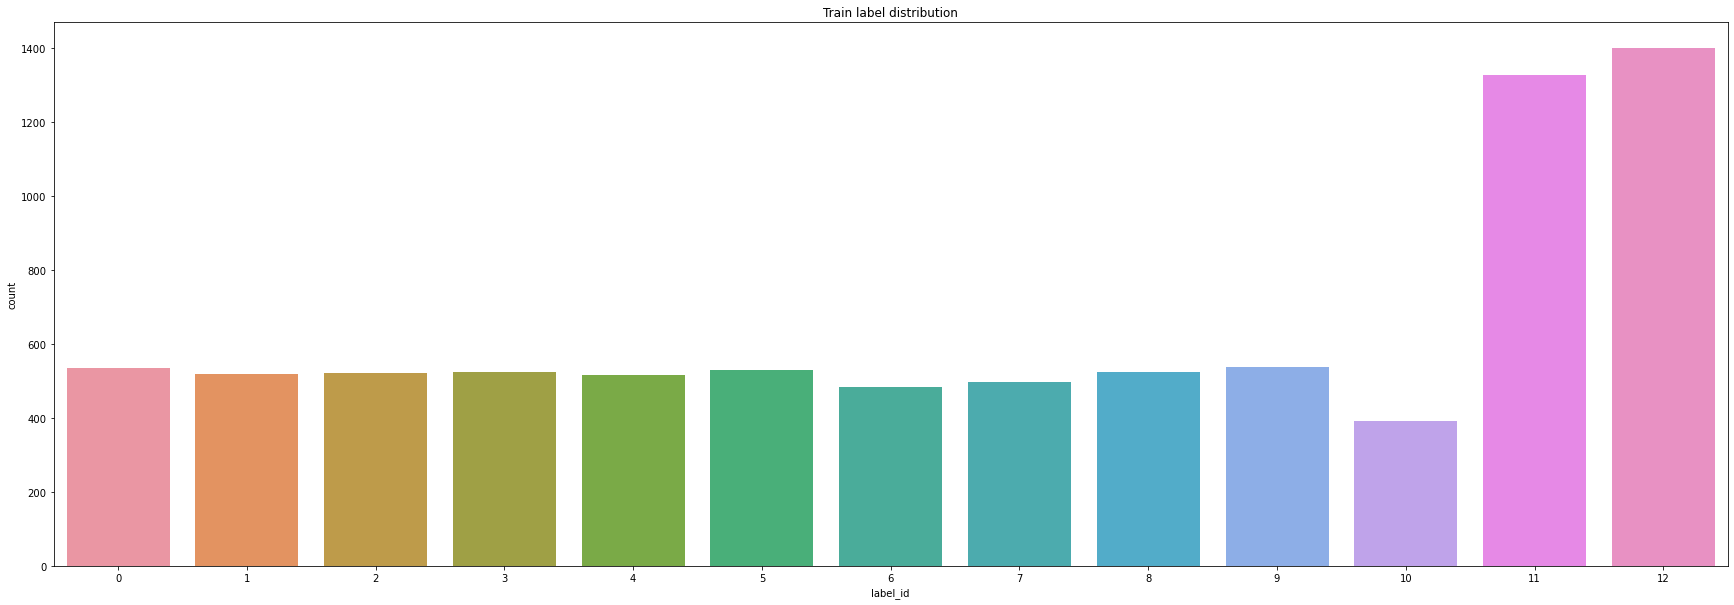

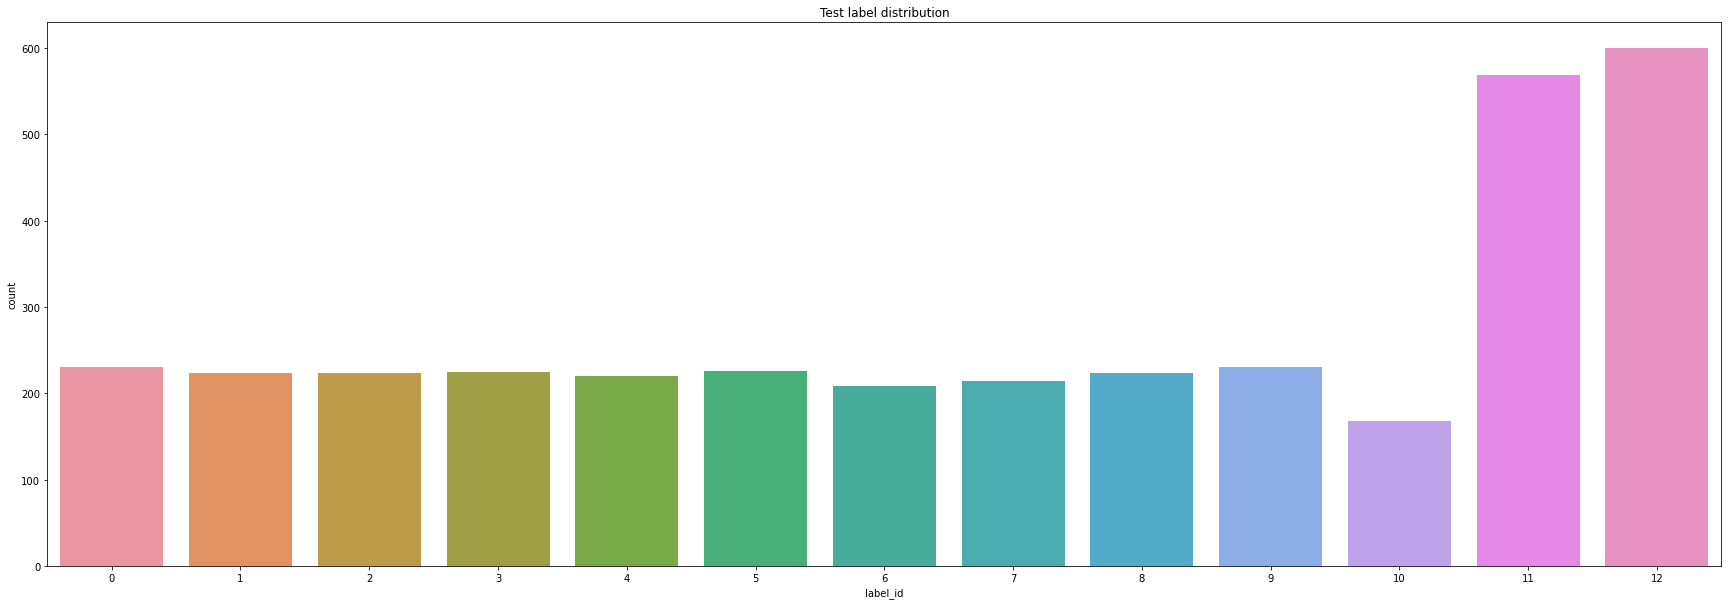

In [10]:
plt.figure(figsize=(30,10))
plt.title("Train label distribution")
sns.countplot(train_df.label_id)
plt.show()

plt.figure(figsize=(30,10))
plt.title("Test label distribution")
sns.countplot(test_df.label_id)
plt.show()

In [11]:
# Prepare result df
result_df = pd.DataFrame(
    columns=[
        'exp_name', 
        'accuracy_val', 'loss_val',
        'accuracy_train', 'loss_train',
        'time'
    ]
)
result_df

,exp_name,accuracy_val,loss_val,accuracy_train,loss_train,time


## Custom CNN (2 layers; Kernel size 3)

In [12]:
DEFAULT_CONFIG = {
    "train_df":train_df,
    "val_df":test_df,
    "exp_name":".temp",
    "train_dataset_class":ImageDataset,
    "train_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                                T.ToTensor(),
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
        "augmentations":albu.Compose([
                        albu.HorizontalFlip(p=0.5),
                        albu.VerticalFlip(p=0.5),

                        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0, shift_limit=0.3, p=0.6, border_mode=0),

                        albu.OneOf(
                            [
                                albu.RandomContrast(p=1),
                                albu.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        albu.RandomRotate90()
                    ]),
    },
    "val_dataset_class":ImageDataset,
    "val_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "train_dataloader_config":{
        "batch_size":32,
        "shuffle":True,
        "drop_last":True,
        "num_workers":os.cpu_count() // 2
    },
    "val_dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":CNNModel,
    "nn_model_config":{
        "model_type":"custom",
        "custom_config":{
            "n_layers":2,
            "kernel_size":3
        },
        "out_channels":13
    },
    "optimizer_init":lambda model: torch.optim.Adam(model.parameters(), lr=0.001),
    "scheduler_init":lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                            optimizer, 
                                            patience=2,
                                            factor=0.25, 
                                            min_lr=1e-6,
                                            mode='max'
                                            ),
    "criterion":nn.CrossEntropyLoss(),
    "n_epochs":N_EPOCHS,
    "distributed":False,
    "catalyst_callbacks":lambda : [
        OptimizerCallback(metric_key="loss", accumulation_steps=1),
        AccuracyCallback(overall_accuracy=True, class_accuracy=None),
        EarlyStoppingCallback(patience=7, metric='overall_accuracy', minimize=False),
    ],
    "main_metric":"overall_accuracy",
    "minimize_metric":False,
    "device":DEVICE
}

start_time = time()
temp_result = catalyst_training(**DEFAULT_CONFIG)
final_time = time() - start_time

result_df = result_df.append({
    "exp_name": "custom_cnn_ks3_layers2",
    "accuracy_val": temp_result['epoch_metrics']['valid_overall_accuracy'],
    "accuracy_train": temp_result['epoch_metrics']['train_overall_accuracy'],
    "loss_val": temp_result['epoch_metrics']['valid_loss'],
    "loss_train": temp_result['epoch_metrics']['train_loss'],
    "time": final_time
}, ignore_index=True)
result_df

CNNModel(
  (base_model): CustomCNN(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (emb_drop): Dropout(p=0.2, inplace=False)
  (mlp_layres): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.1, inplace=False)
    )
  )
  (classifier): Linear(in_features=128, out_features=13, bias=True)
)
1/75 * Epoch (train): 100% 259/259 [00:03<00:00, 76.05it/s, loss=2.206]
1/75 * Epoch (valid): 100% 112/112 [00:00<00:00, 124.58it/s, loss=2.754]
[2020-11-20 11:50:07,957] 
1/75 * Epoch 1 (_base): lr=0.0010 | momentum

,exp_name,accuracy_val,loss_val,accuracy_train,loss_train,time
0,custom_cnn_ks3_layers2,0.396348,1.7666,0.368243,1.841534,170.312951


## Custom CNN (3 layers; Kernel size 3)

In [13]:
DEFAULT_CONFIG = {
    "train_df":train_df,
    "val_df":test_df,
    "exp_name":".temp",
    "train_dataset_class":ImageDataset,
    "train_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                                T.ToTensor(),
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
        "augmentations":albu.Compose([
                        albu.HorizontalFlip(p=0.5),
                        albu.VerticalFlip(p=0.5),

                        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0, shift_limit=0.3, p=0.6, border_mode=0),

                        albu.OneOf(
                            [
                                albu.RandomContrast(p=1),
                                albu.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        albu.RandomRotate90()
                    ]),
    },
    "val_dataset_class":ImageDataset,
    "val_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "train_dataloader_config":{
        "batch_size":32,
        "shuffle":True,
        "drop_last":True,
        "num_workers":os.cpu_count() // 2
    },
    "val_dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":CNNModel,
    "nn_model_config":{
        "model_type":"custom",
        "custom_config":{
            "n_layers":3,
            "kernel_size":3
        },
        "out_channels":13
    },
    "optimizer_init":lambda model: torch.optim.Adam(model.parameters(), lr=0.001),
    "scheduler_init":lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                            optimizer, 
                                            patience=2,
                                            factor=0.25, 
                                            min_lr=1e-6,
                                            mode='max'
                                            ),
    "criterion":nn.CrossEntropyLoss(),
    "n_epochs":N_EPOCHS,
    "distributed":False,
    "catalyst_callbacks":lambda : [
        OptimizerCallback(metric_key="loss", accumulation_steps=1),
        AccuracyCallback(overall_accuracy=True, class_accuracy=None),
        EarlyStoppingCallback(patience=7, metric='overall_accuracy', minimize=False),
    ],
    "main_metric":"overall_accuracy",
    "minimize_metric":False,
    "device":DEVICE
}

start_time = time()
temp_result = catalyst_training(**DEFAULT_CONFIG)
final_time = time() - start_time

result_df = result_df.append({
    "exp_name": "custom_cnn_ks3_layers3",
    "accuracy_val": temp_result['epoch_metrics']['valid_overall_accuracy'],
    "accuracy_train": temp_result['epoch_metrics']['train_overall_accuracy'],
    "loss_val": temp_result['epoch_metrics']['valid_loss'],
    "loss_train": temp_result['epoch_metrics']['train_loss'],
    "time": final_time
}, ignore_index=True)
result_df

CNNModel(
  (base_model): CustomCNN(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (emb_drop): Dropout(p=0.2, inplace=False)
  (mlp_layres): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.1, inplace=False)
    )
  )
  (classifier): Linear(in_features=128, out_features=13, bias=True)
)
1/75 * Epoch (

,exp_name,accuracy_val,loss_val,accuracy_train,loss_train,time
0,custom_cnn_ks3_layers2,0.396348,1.766600,0.368243,1.841534,170.312951
1,custom_cnn_ks3_layers3,0.420506,1.701146,0.391289,1.778756,178.476369


## Custom CNN (4 layers; Kernel size 3)

In [14]:
DEFAULT_CONFIG = {
    "train_df":train_df,
    "val_df":test_df,
    "exp_name":".temp",
    "train_dataset_class":ImageDataset,
    "train_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                                T.ToTensor(),
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
        "augmentations":albu.Compose([
                        albu.HorizontalFlip(p=0.5),
                        albu.VerticalFlip(p=0.5),

                        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0, shift_limit=0.3, p=0.6, border_mode=0),

                        albu.OneOf(
                            [
                                albu.RandomContrast(p=1),
                                albu.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        albu.RandomRotate90()
                    ]),
    },
    "val_dataset_class":ImageDataset,
    "val_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "train_dataloader_config":{
        "batch_size":32,
        "shuffle":True,
        "drop_last":True,
        "num_workers":os.cpu_count() // 2
    },
    "val_dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":CNNModel,
    "nn_model_config":{
        "model_type":"custom",
        "custom_config":{
            "n_layers":4,
            "kernel_size":3
        },
        "out_channels":13
    },
    "optimizer_init":lambda model: torch.optim.Adam(model.parameters(), lr=0.001),
    "scheduler_init":lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                            optimizer, 
                                            patience=2,
                                            factor=0.25, 
                                            min_lr=1e-6,
                                            mode='max'
                                            ),
    "criterion":nn.CrossEntropyLoss(),
    "n_epochs":N_EPOCHS,
    "distributed":False,
    "catalyst_callbacks":lambda : [
        OptimizerCallback(metric_key="loss", accumulation_steps=1),
        AccuracyCallback(overall_accuracy=True, class_accuracy=None),
        EarlyStoppingCallback(patience=7, metric='overall_accuracy', minimize=False),
    ],
    "main_metric":"overall_accuracy",
    "minimize_metric":False,
    "device":DEVICE
}

start_time = time()
temp_result = catalyst_training(**DEFAULT_CONFIG)
final_time = time() - start_time

result_df = result_df.append({
    "exp_name": "custom_cnn_ks3_layers4",
    "accuracy_val": temp_result['epoch_metrics']['valid_overall_accuracy'],
    "accuracy_train": temp_result['epoch_metrics']['train_overall_accuracy'],
    "loss_val": temp_result['epoch_metrics']['valid_loss'],
    "loss_train": temp_result['epoch_metrics']['train_loss'],
    "time": final_time
}, ignore_index=True)
result_df

CNNModel(
  (base_model): CustomCNN(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (3): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (emb_drop): Dropout(p=0.2, inplace=False)
  (mlp_layres): ModuleList(
    (0): Sequential(
      (0): Linear(in_f

,exp_name,accuracy_val,loss_val,accuracy_train,loss_train,time
0,custom_cnn_ks3_layers2,0.396348,1.766600,0.368243,1.841534,170.312951
1,custom_cnn_ks3_layers3,0.420506,1.701146,0.391289,1.778756,178.476369
2,custom_cnn_ks3_layers4,0.574438,1.305960,0.513152,1.415954,352.378475


## Custom CNN (4 layers; Kernel size 5)

In [15]:
DEFAULT_CONFIG = {
    "train_df":train_df,
    "val_df":test_df,
    "exp_name":".temp",
    "train_dataset_class":ImageDataset,
    "train_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                                T.ToTensor(),
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
        "augmentations":albu.Compose([
                        albu.HorizontalFlip(p=0.5),
                        albu.VerticalFlip(p=0.5),

                        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0, shift_limit=0.3, p=0.6, border_mode=0),

                        albu.OneOf(
                            [
                                albu.RandomContrast(p=1),
                                albu.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        albu.RandomRotate90()
                    ]),
    },
    "val_dataset_class":ImageDataset,
    "val_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "train_dataloader_config":{
        "batch_size":32,
        "shuffle":True,
        "drop_last":True,
        "num_workers":os.cpu_count() // 2
    },
    "val_dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":CNNModel,
    "nn_model_config":{
        "model_type":"custom",
        "custom_config":{
            "n_layers":4,
            "kernel_size":5
        },
        "out_channels":13
    },
    "optimizer_init":lambda model: torch.optim.Adam(model.parameters(), lr=0.001),
    "scheduler_init":lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                            optimizer, 
                                            patience=2,
                                            factor=0.25, 
                                            min_lr=1e-6,
                                            mode='max'
                                            ),
    "criterion":nn.CrossEntropyLoss(),
    "n_epochs":N_EPOCHS,
    "distributed":False,
    "catalyst_callbacks":lambda : [
        OptimizerCallback(metric_key="loss", accumulation_steps=1),
        AccuracyCallback(overall_accuracy=True, class_accuracy=None),
        EarlyStoppingCallback(patience=7, metric='overall_accuracy', minimize=False),
    ],
    "main_metric":"overall_accuracy",
    "minimize_metric":False,
    "device":DEVICE
}

start_time = time()
temp_result = catalyst_training(**DEFAULT_CONFIG)
final_time = time() - start_time

result_df = result_df.append({
    "exp_name": "custom_cnn_ks5_layers4",
    "accuracy_val": temp_result['epoch_metrics']['valid_overall_accuracy'],
    "accuracy_train": temp_result['epoch_metrics']['train_overall_accuracy'],
    "loss_val": temp_result['epoch_metrics']['valid_loss'],
    "loss_train": temp_result['epoch_metrics']['train_loss'],
    "time": final_time
}, ignore_index=True)
result_df

CNNModel(
  (base_model): CustomCNN(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (3): Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (emb_drop): Dropout(p=0.2, inplace=False)
  (mlp_layres): ModuleList(
    (0): Sequential(
      (0): Linear(in_f

,exp_name,accuracy_val,loss_val,accuracy_train,loss_train,time
0,custom_cnn_ks3_layers2,0.396348,1.766600,0.368243,1.841534,170.312951
1,custom_cnn_ks3_layers3,0.420506,1.701146,0.391289,1.778756,178.476369
2,custom_cnn_ks3_layers4,0.574438,1.305960,0.513152,1.415954,352.378475
3,custom_cnn_ks5_layers4,0.617416,1.193608,0.532939,1.380903,374.510828


## Custom CNN (4 layers; Kernel size 5; 2 MLP layers)

In [16]:
DEFAULT_CONFIG = {
    "train_df":train_df,
    "val_df":test_df,
    "exp_name":".temp",
    "train_dataset_class":ImageDataset,
    "train_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                                T.ToTensor(),
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
        "augmentations":albu.Compose([
                        albu.HorizontalFlip(p=0.5),
                        albu.VerticalFlip(p=0.5),

                        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0, shift_limit=0.3, p=0.6, border_mode=0),

                        albu.OneOf(
                            [
                                albu.RandomContrast(p=1),
                                albu.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        albu.RandomRotate90()
                    ]),
    },
    "val_dataset_class":ImageDataset,
    "val_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "train_dataloader_config":{
        "batch_size":32,
        "shuffle":True,
        "drop_last":True,
        "num_workers":os.cpu_count() // 2
    },
    "val_dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":CNNModel,
    "nn_model_config":{
        "model_type":"custom",
        "n_mlp_layers": 2,
        "custom_config":{
            "n_layers":4,
            "kernel_size":5
        },
        "out_channels":13
    },
    "optimizer_init":lambda model: torch.optim.Adam(model.parameters(), lr=0.001),
    "scheduler_init":lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                            optimizer, 
                                            patience=2,
                                            factor=0.25, 
                                            min_lr=1e-6,
                                            mode='max'
                                            ),
    "criterion":nn.CrossEntropyLoss(),
    "n_epochs":N_EPOCHS,
    "distributed":False,
    "catalyst_callbacks":lambda : [
        OptimizerCallback(metric_key="loss", accumulation_steps=1),
        AccuracyCallback(overall_accuracy=True, class_accuracy=None),
        EarlyStoppingCallback(patience=7, metric='overall_accuracy', minimize=False),
    ],
    "main_metric":"overall_accuracy",
    "minimize_metric":False,
    "device":DEVICE
}

start_time = time()
temp_result = catalyst_training(**DEFAULT_CONFIG)
final_time = time() - start_time

result_df = result_df.append({
    "exp_name": "custom_cnn_ks5_layers4_2mlp",
    "accuracy_val": temp_result['epoch_metrics']['valid_overall_accuracy'],
    "accuracy_train": temp_result['epoch_metrics']['train_overall_accuracy'],
    "loss_val": temp_result['epoch_metrics']['valid_loss'],
    "loss_train": temp_result['epoch_metrics']['train_loss'],
    "time": final_time
}, ignore_index=True)
result_df

CNNModel(
  (base_model): CustomCNN(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (3): Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (emb_drop): Dropout(p=0.2, inplace=False)
  (mlp_layres): ModuleList(
    (0): Sequential(
      (0): Linear(in_f

,exp_name,accuracy_val,loss_val,accuracy_train,loss_train,time
0,custom_cnn_ks3_layers2,0.396348,1.766600,0.368243,1.841534,170.312951
1,custom_cnn_ks3_layers3,0.420506,1.701146,0.391289,1.778756,178.476369
2,custom_cnn_ks3_layers4,0.574438,1.305960,0.513152,1.415954,352.378475
3,custom_cnn_ks5_layers4,0.617416,1.193608,0.532939,1.380903,374.510828
4,custom_cnn_ks5_layers4_2mlp,0.408989,1.676293,0.388031,1.755985,229.900820


## Resnet50 (Imagenet)

In [17]:
DEFAULT_CONFIG = {
    "train_df":train_df,
    "val_df":test_df,
    "exp_name":".temp",
    "train_dataset_class":ImageDataset,
    "train_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                                T.ToTensor(),
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
        "augmentations":albu.Compose([
                        albu.HorizontalFlip(p=0.5),
                        albu.VerticalFlip(p=0.5),

                        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0, shift_limit=0.3, p=0.6, border_mode=0),

                        albu.OneOf(
                            [
                                albu.RandomContrast(p=1),
                                albu.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        albu.RandomRotate90()
                    ]),
    },
    "val_dataset_class":ImageDataset,
    "val_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "train_dataloader_config":{
        "batch_size":32,
        "shuffle":True,
        "drop_last":True,
        "num_workers":os.cpu_count() // 2
    },
    "val_dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":CNNModel,
    "nn_model_config":{
        "model_type":"resnet50",
        "n_mlp_layers": 1,
        "out_channels":13
    },
    "optimizer_init":lambda model: torch.optim.Adam(model.parameters(), lr=0.001),
    "scheduler_init":lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                            optimizer, 
                                            patience=2,
                                            factor=0.25, 
                                            min_lr=1e-6,
                                            mode='max'
                                            ),
    "criterion":nn.CrossEntropyLoss(),
    "n_epochs":N_EPOCHS,
    "distributed":False,
    "catalyst_callbacks":lambda : [
        OptimizerCallback(metric_key="loss", accumulation_steps=1),
        AccuracyCallback(overall_accuracy=True, class_accuracy=None),
        EarlyStoppingCallback(patience=7, metric='overall_accuracy', minimize=False),
    ],
    "main_metric":"overall_accuracy",
    "minimize_metric":False,
    "device":DEVICE
}

start_time = time()
temp_result = catalyst_training(**DEFAULT_CONFIG)
final_time = time() - start_time

result_df = result_df.append({
    "exp_name": "resnet50_imagenet",
    "accuracy_val": temp_result['epoch_metrics']['valid_overall_accuracy'],
    "accuracy_train": temp_result['epoch_metrics']['train_overall_accuracy'],
    "loss_val": temp_result['epoch_metrics']['valid_loss'],
    "loss_train": temp_result['epoch_metrics']['train_loss'],
    "time": final_time
}, ignore_index=True)
result_df

CNNModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

,exp_name,accuracy_val,loss_val,accuracy_train,loss_train,time
0,custom_cnn_ks3_layers2,0.396348,1.766600,0.368243,1.841534,170.312951
1,custom_cnn_ks3_layers3,0.420506,1.701146,0.391289,1.778756,178.476369
2,custom_cnn_ks3_layers4,0.574438,1.305960,0.513152,1.415954,352.378475
3,custom_cnn_ks5_layers4,0.617416,1.193608,0.532939,1.380903,374.510828
4,custom_cnn_ks5_layers4_2mlp,0.408989,1.676293,0.388031,1.755985,229.900820
5,resnet50_imagenet,0.793820,0.746003,0.818412,0.566852,1175.523618


## Resnet 50 (sratch)

In [ ]:
DEFAULT_CONFIG = {
    "train_df":train_df,
    "val_df":test_df,
    "exp_name":".temp",
    "train_dataset_class":ImageDataset,
    "train_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                                T.ToTensor(),
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
        "augmentations":albu.Compose([
                        albu.HorizontalFlip(p=0.5),
                        albu.VerticalFlip(p=0.5),

                        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0, shift_limit=0.3, p=0.6, border_mode=0),

                        albu.OneOf(
                            [
                                albu.RandomContrast(p=1),
                                albu.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        albu.RandomRotate90()
                    ]),
    },
    "val_dataset_class":ImageDataset,
    "val_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "train_dataloader_config":{
        "batch_size":32,
        "shuffle":True,
        "drop_last":True,
        "num_workers":os.cpu_count() // 2
    },
    "val_dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":CNNModel,
    "nn_model_config":{
        "model_type":"resnet50",
        "n_mlp_layers": 1,
        "out_channels":13,
        "pretrained": False
    },
    "optimizer_init":lambda model: torch.optim.Adam(model.parameters(), lr=0.001),
    "scheduler_init":lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                            optimizer, 
                                            patience=2,
                                            factor=0.25, 
                                            min_lr=1e-6,
                                            mode='max'
                                            ),
    "criterion":nn.CrossEntropyLoss(),
    "n_epochs":N_EPOCHS,
    "distributed":False,
    "catalyst_callbacks":lambda : [
        OptimizerCallback(metric_key="loss", accumulation_steps=1),
        AccuracyCallback(overall_accuracy=True, class_accuracy=None),
        EarlyStoppingCallback(patience=7, metric='overall_accuracy', minimize=False),
    ],
    "main_metric":"overall_accuracy",
    "minimize_metric":False,
    "device":DEVICE
}

start_time = time()
temp_result = catalyst_training(**DEFAULT_CONFIG)
final_time = time() - start_time

result_df = result_df.append({
    "exp_name": "resnet50_scratch",
    "accuracy_val": temp_result['epoch_metrics']['valid_overall_accuracy'],
    "accuracy_train": temp_result['epoch_metrics']['train_overall_accuracy'],
    "loss_val": temp_result['epoch_metrics']['valid_loss'],
    "loss_train": temp_result['epoch_metrics']['train_loss'],
    "time": final_time
}, ignore_index=True)
result_df

CNNModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

## VGG16 (Imagenet)

In [ ]:
DEFAULT_CONFIG = {
    "train_df":train_df,
    "val_df":test_df,
    "exp_name":".temp",
    "train_dataset_class":ImageDataset,
    "train_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                                T.ToTensor(),
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
        "augmentations":albu.Compose([
                        albu.HorizontalFlip(p=0.5),
                        albu.VerticalFlip(p=0.5),

                        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0, shift_limit=0.3, p=0.6, border_mode=0),

                        albu.OneOf(
                            [
                                albu.RandomContrast(p=1),
                                albu.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        albu.RandomRotate90()
                    ]),
    },
    "val_dataset_class":ImageDataset,
    "val_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "train_dataloader_config":{
        "batch_size":32,
        "shuffle":True,
        "drop_last":True,
        "num_workers":os.cpu_count() // 2
    },
    "val_dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":CNNModel,
    "nn_model_config":{
        "model_type":"vgg16",
        "n_mlp_layers": 1,
        "out_channels":13
    },
    "optimizer_init":lambda model: torch.optim.Adam(model.parameters(), lr=0.001),
    "scheduler_init":lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                            optimizer, 
                                            patience=2,
                                            factor=0.25, 
                                            min_lr=1e-6,
                                            mode='max'
                                            ),
    "criterion":nn.CrossEntropyLoss(),
    "n_epochs":N_EPOCHS,
    "distributed":False,
    "catalyst_callbacks":lambda : [
        OptimizerCallback(metric_key="loss", accumulation_steps=1),
        AccuracyCallback(overall_accuracy=True, class_accuracy=None),
        EarlyStoppingCallback(patience=7, metric='overall_accuracy', minimize=False),
    ],
    "main_metric":"overall_accuracy",
    "minimize_metric":False,
    "device":DEVICE
}

start_time = time()
temp_result = catalyst_training(**DEFAULT_CONFIG)
final_time = time() - start_time

result_df = result_df.append({
    "exp_name": "vgg16_imagenet",
    "accuracy_val": temp_result['epoch_metrics']['valid_overall_accuracy'],
    "accuracy_train": temp_result['epoch_metrics']['train_overall_accuracy'],
    "loss_val": temp_result['epoch_metrics']['valid_loss'],
    "loss_train": temp_result['epoch_metrics']['train_loss'],
    "time": final_time
}, ignore_index=True)
result_df

## VGG16 (Scratch)

In [ ]:
DEFAULT_CONFIG = {
    "train_df":train_df,
    "val_df":test_df,
    "exp_name":".temp",
    "train_dataset_class":ImageDataset,
    "train_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                                T.ToTensor(),
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
        "augmentations":albu.Compose([
                        albu.HorizontalFlip(p=0.5),
                        albu.VerticalFlip(p=0.5),

                        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0, shift_limit=0.3, p=0.6, border_mode=0),

                        albu.OneOf(
                            [
                                albu.RandomContrast(p=1),
                                albu.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        albu.RandomRotate90()
                    ]),
    },
    "val_dataset_class":ImageDataset,
    "val_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "train_dataloader_config":{
        "batch_size":32,
        "shuffle":True,
        "drop_last":True,
        "num_workers":os.cpu_count() // 2
    },
    "val_dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":CNNModel,
    "nn_model_config":{
        "model_type":"vgg16",
        "n_mlp_layers": 1,
        "out_channels":13,
        "pretrained": False
    },
    "optimizer_init":lambda model: torch.optim.Adam(model.parameters(), lr=0.001),
    "scheduler_init":lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                            optimizer, 
                                            patience=2,
                                            factor=0.25, 
                                            min_lr=1e-6,
                                            mode='max'
                                            ),
    "criterion":nn.CrossEntropyLoss(),
    "n_epochs":N_EPOCHS,
    "distributed":False,
    "catalyst_callbacks":lambda : [
        OptimizerCallback(metric_key="loss", accumulation_steps=1),
        AccuracyCallback(overall_accuracy=True, class_accuracy=None),
        EarlyStoppingCallback(patience=7, metric='overall_accuracy', minimize=False),
    ],
    "main_metric":"overall_accuracy",
    "minimize_metric":False,
    "device":DEVICE
}

start_time = time()
temp_result = catalyst_training(**DEFAULT_CONFIG)
final_time = time() - start_time

result_df = result_df.append({
    "exp_name": "vgg16_sratch",
    "accuracy_val": temp_result['epoch_metrics']['valid_overall_accuracy'],
    "accuracy_train": temp_result['epoch_metrics']['train_overall_accuracy'],
    "loss_val": temp_result['epoch_metrics']['valid_loss'],
    "loss_train": temp_result['epoch_metrics']['train_loss'],
    "time": final_time
}, ignore_index=True)
result_df

## Effnet B1 (Noisy Student)

In [ ]:
DEFAULT_CONFIG = {
    "train_df":train_df,
    "val_df":test_df,
    "exp_name":".temp",
    "train_dataset_class":ImageDataset,
    "train_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                                T.ToTensor(),
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
        "augmentations":albu.Compose([
                        albu.HorizontalFlip(p=0.5),
                        albu.VerticalFlip(p=0.5),

                        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0, shift_limit=0.3, p=0.6, border_mode=0),

                        albu.OneOf(
                            [
                                albu.RandomContrast(p=1),
                                albu.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        albu.RandomRotate90()
                    ]),
    },
    "val_dataset_class":ImageDataset,
    "val_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "train_dataloader_config":{
        "batch_size":32,
        "shuffle":True,
        "drop_last":True,
        "num_workers":os.cpu_count() // 2
    },
    "val_dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":CNNModel,
    "nn_model_config":{
        "model_type":"effnet",
        "n_mlp_layers": 1,
        "out_channels":13,
    },
    "optimizer_init":lambda model: torch.optim.Adam(model.parameters(), lr=0.001),
    "scheduler_init":lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                            optimizer, 
                                            patience=2,
                                            factor=0.25, 
                                            min_lr=1e-6,
                                            mode='max'
                                            ),
    "criterion":nn.CrossEntropyLoss(),
    "n_epochs":N_EPOCHS,
    "distributed":False,
    "catalyst_callbacks":lambda : [
        OptimizerCallback(metric_key="loss", accumulation_steps=1),
        AccuracyCallback(overall_accuracy=True, class_accuracy=None),
        EarlyStoppingCallback(patience=7, metric='overall_accuracy', minimize=False),
    ],
    "main_metric":"overall_accuracy",
    "minimize_metric":False,
    "device":DEVICE
}

start_time = time()
temp_result = catalyst_training(**DEFAULT_CONFIG)
final_time = time() - start_time

result_df = result_df.append({
    "exp_name": "effnetb1_noisystudnet",
    "accuracy_val": temp_result['epoch_metrics']['valid_overall_accuracy'],
    "accuracy_train": temp_result['epoch_metrics']['train_overall_accuracy'],
    "loss_val": temp_result['epoch_metrics']['valid_loss'],
    "loss_train": temp_result['epoch_metrics']['train_loss'],
    "time": final_time
}, ignore_index=True)
result_df

## Effnet B1 (Scratch)

In [ ]:
DEFAULT_CONFIG = {
    "train_df":train_df,
    "val_df":test_df,
    "exp_name":".temp",
    "train_dataset_class":ImageDataset,
    "train_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                                T.ToTensor(),
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
        "augmentations":albu.Compose([
                        albu.HorizontalFlip(p=0.5),
                        albu.VerticalFlip(p=0.5),

                        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0, shift_limit=0.3, p=0.6, border_mode=0),

                        albu.OneOf(
                            [
                                albu.RandomContrast(p=1),
                                albu.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        albu.RandomRotate90()
                    ]),
    },
    "val_dataset_class":ImageDataset,
    "val_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "train_dataloader_config":{
        "batch_size":32,
        "shuffle":True,
        "drop_last":True,
        "num_workers":os.cpu_count() // 2
    },
    "val_dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":CNNModel,
    "nn_model_config":{
        "model_type":"effnet",
        "n_mlp_layers": 1,
        "out_channels":13,
        "pretrained": False
    },
    "optimizer_init":lambda model: torch.optim.Adam(model.parameters(), lr=0.001),
    "scheduler_init":lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                            optimizer, 
                                            patience=2,
                                            factor=0.25, 
                                            min_lr=1e-6,
                                            mode='max'
                                            ),
    "criterion":nn.CrossEntropyLoss(),
    "n_epochs":N_EPOCHS,
    "distributed":False,
    "catalyst_callbacks":lambda : [
        OptimizerCallback(metric_key="loss", accumulation_steps=1),
        AccuracyCallback(overall_accuracy=True, class_accuracy=None),
        EarlyStoppingCallback(patience=7, metric='overall_accuracy', minimize=False),
    ],
    "main_metric":"overall_accuracy",
    "minimize_metric":False,
    "device":DEVICE
}

start_time = time()
temp_result = catalyst_training(**DEFAULT_CONFIG)
final_time = time() - start_time

result_df = result_df.append({
    "exp_name": "effnetb1_scratch",
    "accuracy_val": temp_result['epoch_metrics']['valid_overall_accuracy'],
    "accuracy_train": temp_result['epoch_metrics']['train_overall_accuracy'],
    "loss_val": temp_result['epoch_metrics']['valid_loss'],
    "loss_train": temp_result['epoch_metrics']['train_loss'],
    "time": final_time
}, ignore_index=True)
result_df

## Results

In [26]:
result_df = result_df.sort_values('accuracy_val', ascending=False).reset_index(drop=True)
result_df

,exp_name,accuracy_val,loss_val,accuracy_train,loss_train,time
0,effnetb1_noisystudnet,0.828652,0.760622,0.932794,0.210171,526.455100
1,resnet50_imagenet,0.793820,0.746003,0.818412,0.566852,1175.523618
2,custom_cnn_ks5_layers4,0.617416,1.193608,0.532939,1.380903,374.510828
3,resnet50_scratch,0.580899,1.351355,0.529681,1.389399,1178.765599
4,custom_cnn_ks3_layers4,0.574438,1.305960,0.513152,1.415954,352.378475
5,vgg16_imagenet,0.571067,1.281038,0.536800,1.339180,1825.463588
6,vgg16_sratch,0.564888,1.328504,0.522925,1.386828,2349.153263
7,effnetb1_scratch,0.545787,1.374313,0.482867,1.492817,1424.830521
8,custom_cnn_ks3_layers3,0.420506,1.701146,0.391289,1.778756,178.476369
9,custom_cnn_ks5_layers4_2mlp,0.408989,1.676293,0.388031,1.755985,229.900820


In [27]:
result_df.to_csv('nn_results.csv', index=False)